<a href="https://colab.research.google.com/github/alchua1996/MachineLearning/blob/master/creditcard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this notebook, we'll be dealing with credit card fraud dataset. Instances of credit card fraud, are marked as 1 (which we'll call a "positive"), and instances of legitimate transactions are marked as (which we'll deem as a "negative"). This is an infamous example of an imbalanced dataset since credit card fraud is a very small percentange of transactions.

Our goal with a model would be high accuracy, but some mistakes are more costly than others. In this case, we want to reduce the amount of false negatives, or transactions that were fraud and not detected as fraud, as much as possible. These are the transactions that will lead to the most trouble for the consumer and credit card companies. False positives, or transactions that were legitimate and marked as fraud, will only cause minor inconvience to the customer. With this in mind, we'll attempt to lower false negatives, yet still aim for high accuracy in our models.

## About Data


This dataset has credit card transactions from Eurpoean cardholders.This dataset 492 fraudulent transactions out of a total of 284,807 transactions. The amount of fraud is less than 0.2% of the total transactions. 

The features are all numerical. There are 30 features in total, and the features V1, V2,..., V28 were obtained by applying PCA to the original data, and the variables 'Time' and 'Amount' represent the time after the first transaction and the amount of the transaction, respectively.

## Importing Libraries


In [ ]:
#basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#preprocessing
from sklearn.preprocessing import StandardScaler

#Pipeline
import sklearn.pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

#evaluation
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

#machine learning algorithms
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

## Load Data and Graph

Let's drop the 'Time' variable in our analysis. It might be useful, but let's keep everything simple.

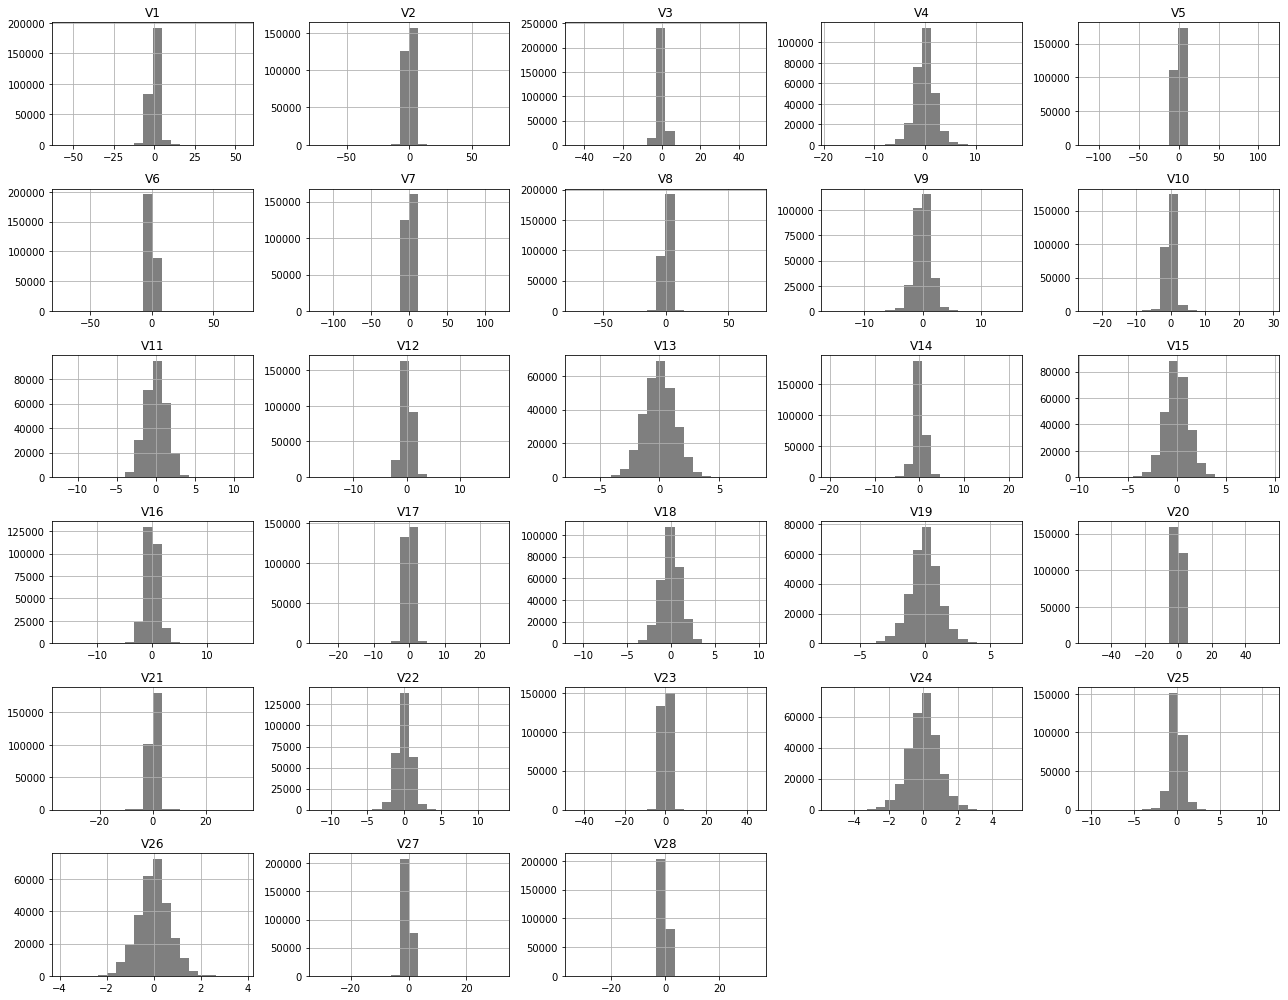

In [ ]:
df = pd.read_csv('/content/drive/My Drive/creditcard.csv')
df.drop(columns = ['Time'])

feature_df = df.drop(columns = ['Time', 'Class'])
plot_df = df.drop(columns = ['Time', 'Class','Amount'])

plot_df.diff().hist(color = 'k', alpha=0.5, bins = 20, figsize=(18, 14))
plt.tight_layout()

y = df['Class'].to_numpy()
X = feature_df.to_numpy()

#make train and test set with 80%/20% split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42)

#scale using standard scaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)



Looking at these histograms, many of the variables have a gaussian-like distribiution. The first thing this suggests is that  Gaussian Naive Bayes might be a good baseline model for this method. 

## Evaluation Metrics

We've chosen to use precision-recall instead of  ROC curves since this is an imbalanced dataset. A short summary of the ROC curve is that it gives a plot of the false positive rate versus the true positive. The true positive rate is heavily favored here, which would indicate good results even if we have a high amount of false negatives. 

First, we'll define the following varialbles:
\begin{align*}
TP &= \text{True Postiive} \\
TN &= \text{True Negative} \\
FP &= \text{False Postiive} \\
FN &= \text{False Negative}.
\end{align*}
Precision is defined as
$${\displaystyle {\text{Precision}}={\frac{TP}{TP+FP}}}$$
and recall is defined as 
$${\displaystyle {\text{Recall}}={\frac {TP}{TP+FN}}.}$$
In this case, our precision measures the perecentage of cases marked as fraud that were correctly marked as fraud and our recall measures the percentage of actual cases of fraud that were correctly classified. The precision-recall curve looks at the tradeoff between the two at different thresholds. In our case, we'd like to have a higher recall at each precision level.

We also want to penalize false negatives the most, so we want to have a high recall above all else to reduce the number of false negatives (since the false positives would most likely outweigh the true positives in this case). Thus, our evaluation metric will actually be recall instead of F1 and MCC.

The idea behind this is the following: the number of true positives we have will be very small in our dataset. So in our calculation of recall, the false negatives will be what cause our recall to shrink. That is, they are directly correlated because of the huge class imbalance.

We have some approaches now:
* We could use SMOTE to rebalance our dataset. If we do this, we'll have a high amount of repeats, but a balanced dataset. This isn't ideal since we won't really learn much from repeating less than 1% of the samples multiple times. In these cases, we could use accuracy as an evaluation metric without any problem.
* We could try undersampling our dataset so that the data is balanced. This approach might lead to an overfit later since our data isn't repreentative of the total number of training samples.
* Lastly, we could use class weights and a different evaluation metric. Since this dataset is so imbalanced, one approach is to use recall as our metric since our recall will be easily affected by false negatives. 

## Models Used

For a baseline model, we'll use Gaussian Naive Bayes based on our analysis above. Then we'll test the following models:
* Random Forest
* XGBoost
* Gradient Boost Decision Tree
* Deep Learning

The choice of these methods is for the following reason: they are highly robust methods and handle nonlinear data well. We'll try to undersample for all these methods, but we can't add class weights for Gradient Boosting, so we'll just run normal Gradient Boosting and undersample. I've tried to oversample, and the results were very similar to the original dataset.

We'll also try to use SVM, Logisitic Regression, and KNN on the undersampled dataset. The methods are too slow for the other datasets, and the training/cross-validation is too long.

# Making New Datasets and Helper Functions

##Undersampled Dataset

Let's now create an undersampled dataset. To still have some imbalance in the data, I chose a 1:10 ratio of positive samples to negative samples, but this could be tweaked.

In [ ]:
X_train_fraud = X_train[y_train == 1]
y_train_fraud = y_train[y_train == 1]
X_train_not = X_train[y_train == 0]
index = np.random.choice(X_train_not.shape[0], 10 * len(y_train_fraud), replace=False)
X_train_new = X_train[index]
y_train_new = np.zeros(len(X_train_new))

X_train_combined = np.vstack((X_train_new, X_train_fraud))
y_train_combined = np.concatenate((y_train_new, y_train_fraud))
y_train_combined = y_train_combined.reshape((len(y_train_combined), 1))
undersampled_data = np.hstack((X_train_combined, y_train_combined))
np.random.shuffle(undersampled_data)

## Helper Functions

In [ ]:
def grid_search_parameters(X, y, parameters, model, metric, cv_num, oversample = False):
    if(oversample == False):
        pipe = sklearn.pipeline.Pipeline([('model', model)])
    else:
        pipe = imblearn.pipeline.Pipeline([('sm', SMOTE()),('model', model)])
    gs = GridSearchCV(pipe, 
                      param_grid = parameters, 
                      scoring = metric,
                      cv = cv_num,
                      verbose = 1)
    gs.fit(X,y)
    gs_dict = gs.best_params_
    print("Best parameters:", gs_dict)
    return gs_dict

In [ ]:
def confusion_mat(y_test, y_pred): 
    mat = confusion_matrix(y_test, y_pred)
    group_names = ['True Negative','False Positive', 'False Negative','True Positive']
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,mat.flatten())]
    labels = np.asarray(labels).reshape(2,2)
    g1 = sns.heatmap(mat, annot=labels, fmt = '', cmap='Blues')
    return

In [ ]:
def pr_curve(y_test, model):
    precision, recall, thresholds = precision_recall_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.figure(figsize = (5,5))
    plt.plot(recall, precision, label = 'PR-curve')
    plt.plot(np.linspace(0,1),np.zeros_like(np.linspace(0,1)), '--',label = 'no skill')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    return 

#Gaussian Naive Bayes

We'll run this with 10-fold cross validation to check our model. 

In [ ]:
gnb_params = [{'model__var_smoothing':[1e-9, 1e-7, 1e-5, 1e-3,1e-1]}]
gnb_dict = grid_search_parameters(X_train, y_train, gnb_params, GaussianNB(), 'recall', 10, oversample = False)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters: {'model__var_smoothing': 1e-09}


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    6.7s finished


In [ ]:
params = [{'gnb__var_smoothing':[1e-9, 1e-7, 1e-5, 1e-3,1e-1]}]
gnb_pipe = sklearn.pipeline.Pipeline([('gnb', GaussianNB())])
gs_gnb = GridSearchCV(gnb_pipe,
                      param_grid=params,
                      scoring='recall',
                      cv = 5,
                      verbose = 1)
gs_gnb.fit(X_train, y_train)
gnb_dict = gs_gnb.best_params_
print("Best parameters:", gnb_dict)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters: {'gnb__var_smoothing': 1e-09}


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    3.6s finished


Let's now train with the best parameters:

In [ ]:
best_gnb = GaussianNB(var_smoothing = gnb_dict['model__var_smoothing'])
best_gnb.fit(X_train, y_train)
gnb_pred = best_gnb.predict(X_test)
gnb_accuracy = accuracy_score(gnb_pred, y_test) * 100
gnb_recall = recall_score(y_test, gnb_pred, average='binary')
print('Accuracy from GNB:', gnb_accuracy)
print('Recall from GNB:', gnb_recall)

Accuracy from GNB: 97.76342122818721
Recall from GNB: 0.8163265306122449


Here is the confusion matrix:

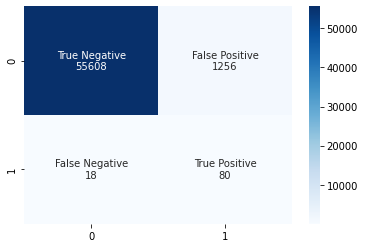

In [ ]:
confusion_mat(y_test, gnb_pred)

Okay, so looking at our confusion matrices, it seems like Gaussian Naive Bayes didn't perform so well. However, most of the errors were false positives, which isn't that bad. Credit to 
[this medium post](https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea) and [this stackoverflow post](https://stackoverflow.com/questions/42712304/seaborn-heatmap-subplots-keep-axis-ratio-consistent) for giving me an idea of how to plot confusion matrices properly. 

Here is the PR-curve:

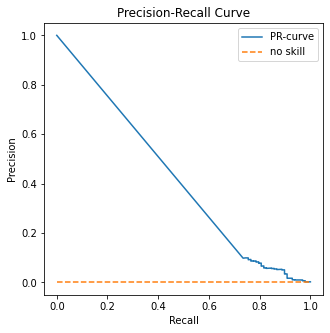

In [ ]:
pr_curve(y_test, best_gnb)

The way to think about a good model is the area under this curve. If the area is larger, then this means that the model is about the have high precision at all thresholds of recall. It's also a good way to check our models just using the eye-test.

# Random Forest

## Class weights

We'll add some weights to our data based on the number of classes. I've tried to do this without weights, and the accuracy is high, but we have so many false negatives. We did a larger grid search beforehand, so this is why our parameter search is so small.

In [ ]:
rf_params = [{'model__n_estimators': [100],
           'model__criterion': ['gini'],
           'model__class_weight': ['balanced_subsample'],
           'model__min_samples_leaf' :[5, 10, 20],
           'model__max_features': ['auto']}]

rf_dict = grid_search_parameters(X_train, y_train, rf_params, RandomForestClassifier(), 'recall', 10, oversample = False)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 60.0min finished


Best parameters: {'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__max_features': 'auto', 'model__min_samples_leaf': 20, 'model__n_estimators': 100}


Here is our classifer using the best parameters from the grid search. We'll then test on the test set. We'll also increase the number of classifiers too.

In [ ]:
best_rf = RandomForestClassifier(class_weight = rf_dict['model__class_weight'],
                                criterion = rf_dict['model__criterion'],
                                n_estimators = 1000,
                                min_samples_leaf = rf_dict['model__min_samples_leaf'],
                                max_features = rf_dict['model__max_features'])
best_rf.fit(X_train, y_train)
rf_pred = best_rf.predict(X_test)
rf_accuracy = accuracy_score(rf_pred, y_test) * 100
rf_recall = recall_score(y_test, rf_pred)
print('Accuracy from RF:', rf_accuracy)
print('Recall from RF:', rf_recall)


Accuracy from RF: 99.94908886626172
Recall from RF: 0.8469387755102041


The run time for this wasn't too long. Here is the confusion matrix now:



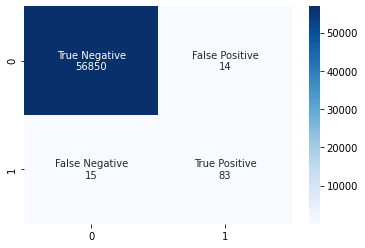

In [ ]:
confusion_mat(y_test, rf_pred)

This performs OK. We would like to reduce the number of false negatives, but this is a good starting point. The goal for our model is to have a very higfh accuracy while detecting all our false negatives. Let's check the Precision-Recall Curves:

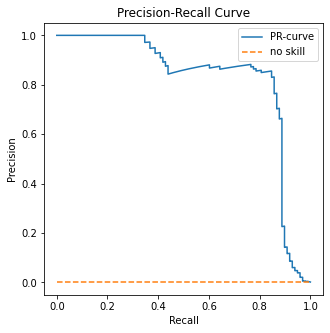

In [ ]:
pr_curve(y_test, best_rf)

Overall, very good! By looking at the area, we can see that this performs much better than the baseline GNB model.

## Undersampling

Let's see if we can improve it by undersampling. When we undersample, let's try using average precision as our metric to reduce the number of false negatives. I've tested recall, and it produces false positives at a rate comparable to GNB, but the number of false negatives doesn't decrease by much. We would have to run some cost analysis to see if 1000 angry customers is better than 4 or 5 cases of fraud. 

In [ ]:
undersampled_rf_params = [{'model__n_estimators': [500],
           'model__criterion': ['gini'],
           'model__class_weight': ['balanced_subsample'],
           'model__min_samples_leaf' :[1, 3, 5, 7, 9, 10],
           'model__max_features': ['auto']}]

u_rf_dict = grid_search_parameters(undersampled_data[:,:-1], 
                                   undersampled_data[:,-1], 
                                   undersampled_rf_params, 
                                   RandomForestClassifier(), 
                                   'average_precision', 10, 
                                   oversample = False)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  7.0min finished


Best parameters: {'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__max_features': 'auto', 'model__min_samples_leaf': 10, 'model__n_estimators': 500}


In [ ]:
undersampled_best_rf = RandomForestClassifier(class_weight = u_rf_dict['model__class_weight'],
                                criterion = u_rf_dict['model__criterion'],
                                n_estimators = 1000,
                                min_samples_leaf = u_rf_dict['model__min_samples_leaf'],
                                max_features = u_rf_dict['model__max_features'])
undersampled_best_rf.fit(undersampled_data[:,:-1], undersampled_data[:,-1])
undersampled_rf_pred = undersampled_best_rf.predict(X_test)
undersampled_rf_accuracy = accuracy_score(undersampled_rf_pred, y_test) * 100
undersampled_rf_recall = recall_score(y_test, undersampled_rf_pred)
print('Accuracy from RF:', undersampled_rf_accuracy)
print('Recall from RF:', undersampled_rf_recall)

Accuracy from RF: 99.59271093009374
Recall from RF: 0.8877551020408163


It looks like our accuracy is lower, but the recall increased slightly. Let's take a look at the confusion matrix for more details.

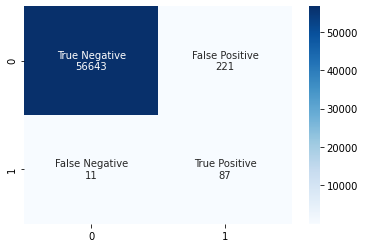

In [ ]:
confusion_mat(y_test,undersampled_rf_pred)

The number of false positives went up by a lot, but we reduced the false negatives by almost 33%. It would be good to analyze how one false negative versus 100 false positives affected consumer retention. I personally think the reduction in false negatives is worth it. 

Here is the PR-curve:

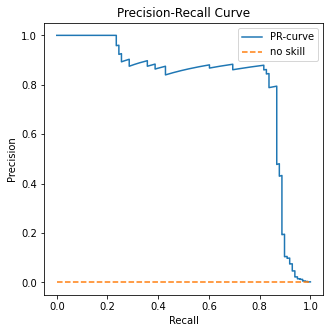

In [ ]:
pr_curve(y_test, undersampled_best_rf)

The precision-recall curve looks comparable to the previous case.

# Gradient Boost Decision Tree

Now, we'll try Gradient Boosting. First, we'll just run one without any sampling to see how it works. For some reason, there is no option to add weights for imbalanced classes. So, I've decided to only undersample. We'll only use 5 cross validations when we don't undersample. Otherwise, the training time will take forever.

## No Sampling

In [ ]:
gbc_params = [{'model__loss': ['deviance'],
         'model__learning_rate': [0.1, 0.01],
         'model__n_estimators': [100],
         'model__min_samples_leaf': [2,5]}]
gbc_dict = grid_search_parameters(X_train, 
                                  y_train, 
                                  gbc_params, 
                                  GradientBoostingClassifier(), 
                                  'recall', 
                                  5, 
                                  oversample = False)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 83.6min finished


Best parameters: {'model__learning_rate': 0.01, 'model__loss': 'deviance', 'model__min_samples_leaf': 2, 'model__n_estimators': 100}


In [ ]:
best_gbc = GradientBoostingClassifier(loss = gbc_dict['model__loss'], 
                                   learning_rate = gbc_dict['model__learning_rate'], 
                                   n_estimators = 200,  
                                   min_samples_leaf = 10)
best_gbc.fit(X_train, y_train)
gbc_pred = best_gbc.predict(X_test)
gbc_accuracy = accuracy_score(gbc_pred, y_test) * 100
gbc_recall = recall_score(y_test, gbc_pred)
print('Accuracy from GBC:', gbc_accuracy)
print('Recall from GBC:', gbc_recall)

Accuracy from GBC: 99.94733330992591
Recall from GBC: 0.7142857142857143


Well, this is very accurate I guess, but Random Forest is just as good. This probably won't work well since it doesn't account for the class imbalance. Let's just look at the confusion matrix and PR curves. They probably won't be good.

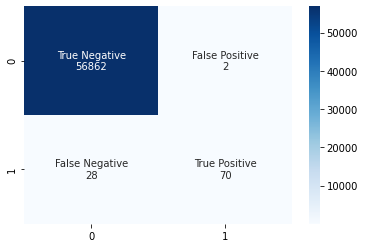

In [ ]:
confusion_mat(y_test, gbc_pred)

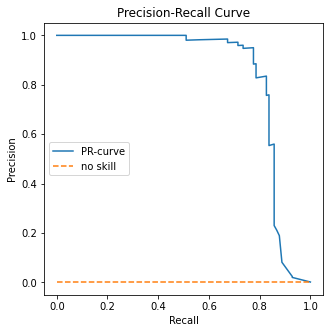

In [ ]:
pr_curve(y_test, best_gbc)

##Undersampling

In [ ]:
undersampled_gbc_params = [{'model__loss': ['deviance'],
         'model__learning_rate': [0.5, 0.1, 0.01],
         'model__n_estimators': [100],
         'model__min_samples_leaf': [2, 4, 6, 8, 10]}]
u_gbc_dict = grid_search_parameters(undersampled_data[:,:-1], 
                                   undersampled_data[:,-1], 
                                   undersampled_gbc_params,  
                                   GradientBoostingClassifier(), 
                                   'recall', 
                                   10, 
                                   oversample = False)

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  8.7min finished


Best parameters: {'model__learning_rate': 0.1, 'model__loss': 'deviance', 'model__min_samples_leaf': 10, 'model__n_estimators': 100}


In [ ]:
undersampled_best_gbc = GradientBoostingClassifier(loss = gbc_dict['model__loss'], 
                                   learning_rate = gbc_dict['model__learning_rate'], 
                                   n_estimators = 200,  
                                   min_samples_leaf = gbc_dict['model__min_samples_leaf'])
undersampled_best_gbc.fit(undersampled_data[:,:-1], undersampled_data[:,-1])
undersampled_gbc_pred = undersampled_best_gbc.predict(X_test)
undersampled_gbc_accuracy = accuracy_score(undersampled_gbc_pred, y_test) * 100
undersampled_gbc_recall = recall_score(y_test, undersampled_gbc_pred)
print('Accuracy from GBC:', undersampled_gbc_accuracy)
print('Recall from GBC:', undersampled_gbc_recall)

Accuracy from GBC: 99.89642217618764
Recall from GBC: 0.8673469387755102


This is more promising. It performs similarly to the Random Forest model from above, and this model can probably be tuned more. It takes a lot of time to run it though, which might make Random Forest a better option. If we look below, the confusion matrix and PR curves look OK, but not good.

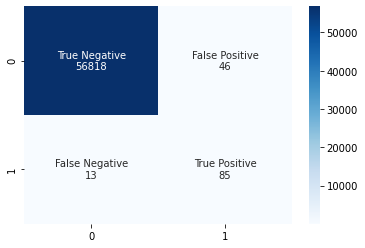

In [ ]:
confusion_mat(y_test, undersampled_gbc_pred)

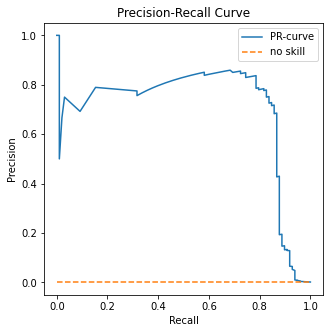

In [ ]:
pr_curve(y_test, undersampled_best_gbc)

#XG Boost

## Class Weights

In [ ]:
positive_instances = np.count_nonzero(y_train)
negative_instances  = len(y_train) - np.count_nonzero(y_train)
weight = negative_instances/positive_instances

In [ ]:
xg_params = [{'model__max_depth':[5, 7, 9],
           'model__eta': [0.1, 0.2],
           'model__n_estimators': [100],
           'model__gamma': [0.1 ,0.2],
           'model__scale_pos_weight': [weight],
           'model__subsample': [0.8],
           'model__colsample_bytree': [0.6],
           'model__min_child_weight':[0.25],
           'model__objective': ['binary:logistic']}]
xg_dict = grid_search_parameters(X_train, 
                                 y_train,
                                 xg_params, 
                                 XGBClassifier(), 
                                 'recall', 
                                 5, 
                                 oversample = False)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 55.9min finished


Best parameters: {'model__colsample_bytree': 0.6, 'model__eta': 0.1, 'model__gamma': 0.1, 'model__max_depth': 5, 'model__min_child_weight': 0.25, 'model__n_estimators': 100, 'model__objective': 'binary:logistic', 'model__scale_pos_weight': 577.2868020304569, 'model__subsample': 0.8}


In [ ]:
best_xgb = XGBClassifier(objective = xg_dict['model__objective'], 
                        eta = xg_dict['model__eta'],
                        n_estimators = 1000,
                        gamma = xg_dict['model__gamma'], 
                        scale_pos_weight = 1000,
                        subsample = xg_dict['model__subsample'],
                        colsample_bytree = xg_dict['model__colsample_bytree'],
                        min_child_weight = xg_dict['model__min_child_weight'])
best_xgb.fit(X_train, y_train)
xgb_pred = best_xgb.predict(X_test)
xgb_accuracy = accuracy_score(xgb_pred, y_test) * 100
xgb_recall = recall_score(y_test, xgb_pred)
print('Accuracy from XG Boost:', xgb_accuracy)
print('Recall from XG Boost:', xgb_recall)

Accuracy from XG Boost: 99.95611109160492
Recall from XG Boost: 0.8469387755102041


The accuracy and recall look OK. Looking at confusion matrix and PR curves below, we see that the methods does well getting rid of false positives, but it does poorly at getting rid of false negatives. With more tuning, this method is promising though.

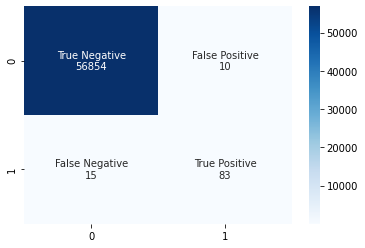

In [ ]:
confusion_mat(y_test, xgb_pred)

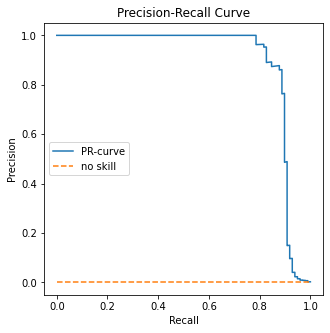

In [ ]:
pr_curve(y_test, best_xgb)

## Undersampling

In [ ]:
u_xg_params = [{'model__max_depth':[3, 5, 7, 9],
           'model__eta': [0.1, 0.2],
           'model__n_estimators': [500],
           'model__gamma': [0, 0.1 , 0.2],
           'model__scale_pos_weight': [10],
           'model__subsample': [0.6, 0.8],
           'model__colsample_bytree': [0.6, 0.8],
           'model__min_child_weight':[0.1, 0.25, 0.5],
           'model__objective': ['binary:logistic']}]
u_xg_dict = grid_search_parameters(undersampled_data[:,:-1], 
                                 undersampled_data[:,-1],
                                 u_xg_params, 
                                 XGBClassifier(), 
                                 'average_precision', 
                                 10, 
                                 oversample = False)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1440 out of 1440 | elapsed: 103.2min finished


Best parameters: {'model__colsample_bytree': 0.6, 'model__eta': 0.1, 'model__gamma': 0.2, 'model__max_depth': 9, 'model__min_child_weight': 0.25, 'model__n_estimators': 500, 'model__objective': 'binary:logistic', 'model__scale_pos_weight': 10, 'model__subsample': 0.8}


In [ ]:
u_best_xgb = XGBClassifier(objective = u_xg_dict['model__objective'], 
                        eta = u_xg_dict['model__eta'],
                        n_estimators = 1000,
                        gamma = u_xg_dict['model__gamma'], 
                        scale_pos_weight = 10,
                        subsample = u_xg_dict['model__subsample'],
                        colsample_bytree = u_xg_dict['model__colsample_bytree'],
                        min_child_weight = u_xg_dict['model__min_child_weight'])
u_best_xgb.fit(undersampled_data[:,:-1], undersampled_data[:,-1])
u_xgb_pred = u_best_xgb.predict(X_test)
u_xgb_accuracy = accuracy_score(u_xgb_pred, y_test) * 100
u_xgb_recall = recall_score(y_test, u_xgb_pred)
print('Accuracy from XG Boost:', u_xgb_accuracy)
print('Recall from XG Boost:', u_xgb_recall)

Accuracy from XG Boost: 99.7436887749728
Recall from XG Boost: 0.9081632653061225


If we sacrifice some accuracy, it seems like this method correctly predicts false negatives very well. The recall increase by 6%, and 2/3 of the false negatives disappeared, so this is actually the most promising idea so far. If we balance our data with a 1:100 ratio, it might be even better.

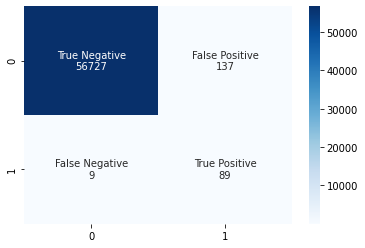

In [ ]:
confusion_mat(y_test, u_xgb_pred)

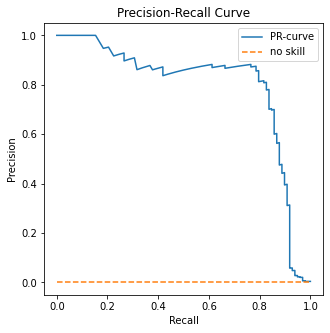

In [ ]:
pr_curve(y_test, u_best_xgb)

#Logistic Regression

This method is probably the simplest method, other than GNB, so it probably won't work too well. It's interesting to test it out though, so let's see what happens.

In [ ]:
lr_params = [{'model__penalty': ['elasticnet'],
         'model__solver': ['saga'],
         'model__class_weight': ['balanced', {0:1, 1:1}],
         'model__C': [1, 0.1, 0.01],
         'model__l1_ratio':[0, 0.1, 0.25, 0.5, 0.75, 0.9, 1],
         'model__max_iter': [10000]}]
lr_dict = grid_search_parameters(undersampled_data[:,:-1], 
                                 undersampled_data[:,-1],
                                 lr_params, 
                                 LogisticRegression(), 
                                 'average_precision', 
                                 10, 
                                 oversample = False)

Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 420 out of 420 | elapsed:  5.5min finished


Best parameters: {'model__C': 0.01, 'model__class_weight': {0: 1, 1: 1}, 'model__l1_ratio': 0.1, 'model__max_iter': 10000, 'model__penalty': 'elasticnet', 'model__solver': 'saga'}


In [ ]:
best_lr = LogisticRegression(penalty = lr_dict['model__penalty'],
                             solver = lr_dict['model__solver'],
                             class_weight = 'balanced',
                             l1_ratio = lr_dict['model__l1_ratio'],
                             C = lr_dict['model__C'],
                             max_iter = 10000) 
best_lr.fit(undersampled_data[:,:-1], undersampled_data[:,-1])
lr_pred = best_lr.predict(X_test)
lr_accuracy = accuracy_score(lr_pred, y_test) * 100
lr_recall = recall_score(y_test, lr_pred)
print('Accuracy from Log Regression:', lr_accuracy)
print('Recall from Log Regression:', lr_recall)

Accuracy from Log Regression: 98.55342157929849
Recall from Log Regression: 0.8979591836734694


This method has a high recall, but the accuracy is very low. The training time is also very low though. I think XG boost/Gradient Boosting is more promising in this case.

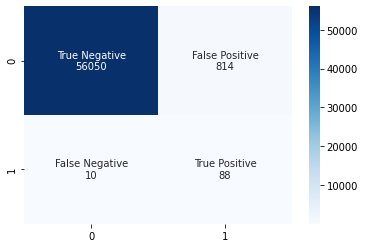

In [ ]:
confusion_mat(y_test, lr_pred)

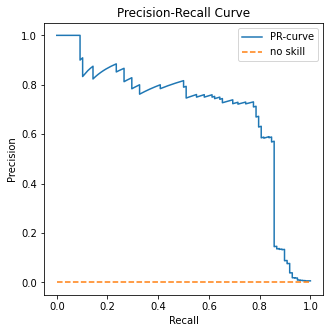

In [ ]:
pr_curve(y_test, best_lr)

#KNN

In [ ]:
knn_params = [{'model__n_neighbors': [3,4,5,6,7],
         'model__weights': ['distance'],
         'model__metric': ['minkowski', 'chebyshev', 'euclidean']}]
knn_dict = grid_search_parameters(undersampled_data[:,:-1], 
                                 undersampled_data[:,-1],
                                 knn_params, 
                                 KNeighborsClassifier(), 
                                 'recall', 
                                 10, 
                                 oversample = False)

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters: {'model__metric': 'minkowski', 'model__n_neighbors': 5, 'model__weights': 'distance'}


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   13.4s finished


In [ ]:
best_knn = KNeighborsClassifier(n_neighbors = knn_dict['model__n_neighbors'], 
                        weights = knn_dict['model__weights'],
                        metric = knn_dict['model__metric'])
best_knn.fit(undersampled_data[:,:-1], undersampled_data[:,-1])
knn_pred = best_knn.predict(X_test)
knn_accuracy = accuracy_score(knn_pred, y_test) * 100
knn_recall = recall_score(y_test, knn_pred)
print('Accuracy from KNN:', knn_accuracy)
print('Recall from KNN:', knn_recall)

Accuracy from KNN: 99.82268881008392
Recall from KNN: 0.8673469387755102


This is actually very promising. The method is accurate, quick, and the recall isn't bad. The best part about the method was the training time. It only took 13.4 seconds for the whole grid search.

This 

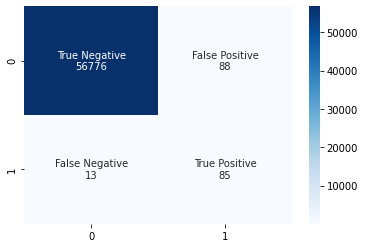

In [ ]:
confusion_mat(y_test, knn_pred)

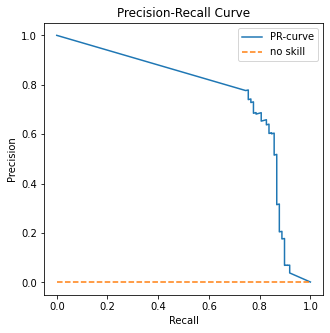

In [ ]:
pr_curve(y_test, best_knn)

#SVM

Like with Logisitic Regression, I don't expect this method to work. SVM uses a soft margin, so the accuracy will be high, but not near 100% like with the other methods we'ved used so far.

In [ ]:
svm_params = [{'model__kernel': ['rbf', 'sigmoid'],
              'model__C': [10, 1, 0.1],
              'model__gamma': ['scale', 'auto'],
              'model__coef0': [-7, -5, -3, -1, -0.1],
              'model__class_weight': ['balanced']}]
svm_dict = grid_search_parameters(undersampled_data[:,:-1], 
                                 undersampled_data[:,-1],
                                 svm_params, 
                                 SVC(), 
                                 'average_precision', 
                                 10, 
                                 oversample = False)

Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:  3.4min finished


Best parameters: {'model__C': 0.1, 'model__class_weight': 'balanced', 'model__coef0': -3, 'model__gamma': 'scale', 'model__kernel': 'sigmoid'}


In [ ]:
best_svm = SVC(kernel = svm_dict['model__kernel'], 
              class_weight = svm_dict['model__class_weight'],
              C = svm_dict['model__C'],
              gamma = svm_dict['model__gamma'],
              coef0 = svm_dict['model__coef0'],
              probability = True)


best_svm.fit(undersampled_data[:,:-1], undersampled_data[:,-1])
svm_pred = best_svm.predict(X_test)
svm_accuracy = accuracy_score(svm_pred, y_test) * 100
svm_recall = recall_score(y_test, svm_pred)
print('Accuracy from SVM:', svm_accuracy)
print('Recall from SVM:', svm_recall)

Accuracy from SVM: 99.78582212703205
Recall from SVM: 0.7857142857142857


This was expected. The method classifies false negatives well, but it does poorly in getting accurate results.

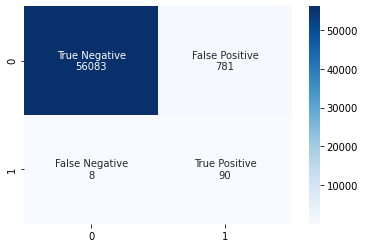

In [ ]:
confusion_mat(y_test, svm_pred)

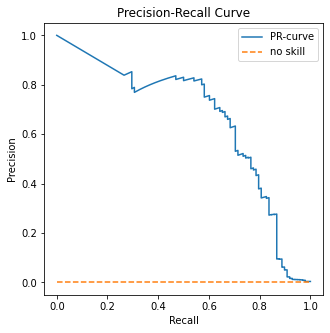

In [ ]:
pr_curve(y_test, best_svm)

# Deep Learning

Now that we've tried some "standard" machine learning algorithms, let's attempt to use a deep learning technique to see the result is any better. we'll just stick to an ANN using pytorch since the point of this project is to demostrate how we'll handle unbalanced data and apply machine learning algorithms.

Using RNN's\LSTM's for this would be a interesting idea to see if the time parameter a signifigant influence, but  this is for a future project.

In [ ]:
#torch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset, DataLoader

In [ ]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.Linear1 = nn.Linear(X_train.shape[1],128)
        self.bn1 = nn.BatchNorm1d(128)
        self.Linear2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.Linear3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.Linear4 = nn.Linear(32, 16)
        self.bn4 = nn.BatchNorm1d(16)
        self.Linear5 = nn.Linear(16, 8)
        self.bn5 = nn.BatchNorm1d(8)
        self.Linear6 = nn.Linear(8, 2)
        self.dropout = nn.Dropout()

    def forward(self, x):
        x = F.relu(self.Linear1(x))
        x = self.bn1(x)
        x = self.dropout(x)
        x = F.relu(self.Linear2(x))
        x = self.bn2(x)
        x = self.dropout(x)
        x = F.relu(self.Linear3(x))
        x = self.bn3(x)
        x = self.dropout(x)
        x = F.relu(self.Linear4(x))
        x = self.bn4(x)
        x = self.dropout(x)
        x = F.relu(self.Linear5(x))
        x = self.bn5(x)
        x = self.dropout(x)
        x = self.Linear6(x)
        return x

def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_uniform(m.weight.data)

In [ ]:
def evaluate(dataloader, model, gpu = True, name = 'Train'):
    correct = 0
    total = 0
    model.eval()
    for data, labels in dataloader:
        if gpu == True:
            data = data.cuda()
            labels = labels.cuda()
        outputs = model(data)
        predicted = torch.argmax(outputs.data, axis = 1)
        total += labels.size(0)
        correct += (predicted.float() == labels).sum()  
    print('{} accuracy: {}'.format(name,(100.0 * correct / total)))
    return

In [ ]:
def train(network, LR, class_weight, EPOCH, train_load, test_load, X_test):    
    model = network
    weights_init(model)
    model = model.cuda()
    loss_func = torch.nn.CrossEntropyLoss(weight = class_weight).cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr = LR)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, .9)
    for epoch in range(EPOCH): 
        model.train() 
        for data, labels in train_load:
            optimizer.zero_grad()
            data = data.cuda()
            labels = labels.cuda()
            output = model(data)  
            loss = loss_func(output, labels.to(torch.int64)) 
            loss.backward()  
            optimizer.step()  
        scheduler.step()
        if ((epoch+1)%10 == 0):
            print('Epoch {}:'.format(epoch+1))
            evaluate(train_load, model, True, 'Train')
            evaluate(test_load, model, True, 'Test')
    model.eval()
    model = model.cpu()
    out = model(X_test)
    y_pred = torch.argmax(out.data, axis = 1)
    return y_pred

## Class Weights

In [ ]:
X_train_tensor = torch.Tensor(X_train)
X_test_tensor = torch.Tensor(X_test)
y_train_tensor = torch.Tensor(y_train)
y_test_tensor = torch.Tensor(y_test)

In [ ]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_load = DataLoader(train_dataset, batch_size=512)
test_load = DataLoader(test_dataset, batch_size=512)

In [ ]:
y_pred = train(ANN(), 1e-3, torch.Tensor([1,100]), 300, train_load, test_load, X_test_tensor)

Epoch 10:
Train accuracy: 99.88456726074219
Test accuracy: 99.90168762207031
Epoch 20:
Train accuracy: 99.8841323852539
Test accuracy: 99.89993286132812
Epoch 30:
Train accuracy: 99.88983917236328
Test accuracy: 99.89993286132812
Epoch 40:
Train accuracy: 99.91310119628906
Test accuracy: 99.91397857666016
Epoch 50:
Train accuracy: 99.88325500488281
Test accuracy: 99.89115905761719
Epoch 60:
Train accuracy: 99.91924285888672
Test accuracy: 99.91924285888672
Epoch 70:
Train accuracy: 99.91616821289062
Test accuracy: 99.91573333740234
Epoch 80:
Train accuracy: 99.87447357177734
Test accuracy: 99.88062286376953
Epoch 90:
Train accuracy: 99.89378356933594
Test accuracy: 99.9034423828125
Epoch 100:
Train accuracy: 99.91836547851562
Test accuracy: 99.91924285888672
Epoch 110:
Train accuracy: 99.89247131347656
Test accuracy: 99.90168762207031
Epoch 120:
Train accuracy: 99.9188003540039
Test accuracy: 99.9209976196289
Epoch 130:
Train accuracy: 99.919677734375
Test accuracy: 99.91924285888672
E

In [ ]:
ann_accuracy = accuracy_score(y_test, y_pred)
ann_recall = recall_score(y_test, y_pred)
print("The accuracy is:", ann_accuracy)
print('The recall is:', ann_recall)

The accuracy is: 0.9992099996488887
The recall is: 0.8469387755102041


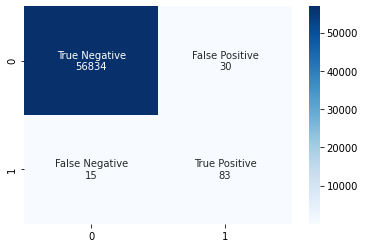

In [ ]:
confusion_mat(y_test, y_pred)

## Undersampling

In [ ]:
undersampled_train = torch.Tensor(undersampled_data[:,:-1])
X_test_tensor = torch.Tensor(X_test)
y_undersampled = torch.Tensor(undersampled_data[:,-1])
y_test_tensor = torch.Tensor(y_test)

In [ ]:
train_dataset = TensorDataset(undersampled_train, y_undersampled)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_load = DataLoader(train_dataset, batch_size=64)
test_load = DataLoader(test_dataset, batch_size=64)

In [ ]:
u_y_pred = train(ANN(), 1e-3, torch.Tensor([1,1]), 300, train_load, test_load, X_test_tensor)

Epoch 10:
Train accuracy: 97.5772933959961
Test accuracy: 99.9227523803711
Epoch 20:
Train accuracy: 98.03875732421875
Test accuracy: 99.93855285644531
Epoch 30:
Train accuracy: 98.13105773925781
Test accuracy: 99.93328857421875
Epoch 40:
Train accuracy: 98.13105773925781
Test accuracy: 99.93504333496094
Epoch 50:
Train accuracy: 98.10797882080078
Test accuracy: 99.93504333496094
Epoch 60:
Train accuracy: 98.08490753173828
Test accuracy: 99.93504333496094
Epoch 70:
Train accuracy: 98.13105773925781
Test accuracy: 99.93328857421875
Epoch 80:
Train accuracy: 98.15412902832031
Test accuracy: 99.92802429199219
Epoch 90:
Train accuracy: 98.13105773925781
Test accuracy: 99.93504333496094
Epoch 100:
Train accuracy: 98.08490753173828
Test accuracy: 99.93504333496094
Epoch 110:
Train accuracy: 98.13105773925781
Test accuracy: 99.93504333496094
Epoch 120:
Train accuracy: 98.13105773925781
Test accuracy: 99.93504333496094
Epoch 130:
Train accuracy: 98.08490753173828
Test accuracy: 99.935043334960

In [ ]:
u_ann_accuracy = accuracy_score(y_test, u_y_pred.detach().numpy())
u_ann_recall = recall_score(y_test, u_y_pred.detach().numpy())
print("The accuracy is:", u_ann_accuracy)
print('The recall is:', u_ann_recall)

The accuracy is: 0.9993504441557529
The recall is: 0.826530612244898


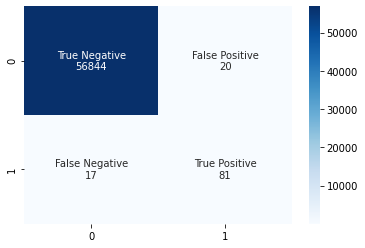

In [ ]:
confusion_mat(y_test, u_y_pred.detach().numpy())

This worked OK, but it's actually expected that this won't be better than other methods. The dataset we found has a PCA applied to it, so some information is lost. It's possible that this is actually a lot of information, or it's only a little bit. Either way, the Neural Network won't do that well because it can actually utilize this information easily compared to the other methods since it will just learn that the nodes from useless information can be ignored.

# Conclusions

This was a good project that taught me a lot of about how to manipulate data. I would like to work on the full data instead of a dataset that had PCA applied to it to see if I can increase the recall without lowering my accuracy too much.

The most promising methods seem to be XG Boost and Gradient Boost Decision Tree based on the accuracy and recall. KNN, Deep Learning, and Random Forest seemed to also be promising as well. 

The recall while undersampling always seemed to be high, but the accuracy wasn't very high. When I have more time, I'd like to balance my data set to a 1:50 ratio to see if the accuracy while undersampling improved. Maybe the simpler methods would work better in this case.